In [ ]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [ ]:
!pip install tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.5/262.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 25.6 MB/s eta 0:00:00
     ━━━━━

In [ ]:
!pip install nest-asyncio
!pip install pandas
!pip install matplotlib

In [ ]:
import collections
import os
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import time

from matplotlib import pyplot as plt

import nest_asyncio
nest_asyncio.apply()

%matplotlib inline

In [ ]:
path = '~/Downloads/Balanced_IEC104_Train_Test_CSV_Files/Balanced_IEC104_Train_Test_CSV_Files/iec104_train_test_csvs'
tp = 'cic'      # Type: choose between 'cic' and 'custom'
tm = 180        # Timeout: choose one value from the following list [15, 30, 60, 90, 120, 180]
n_workers = 2   # #workers: choose between 2 and 5 workers (2 and 5 inclusive)

In [ ]:
assert tp in ('cic', 'custom'), "Wrong dataset type"
assert tm in (15, 30, 60, 90, 120, 180), "Wrong time"
assert 2 <= n_workers <= 5, "At least 2 and at most 5 workers (docker containers) are required"

In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [ ]:
df_train.dtypes

Flow Duration        int64
Tot Fwd Pkts         int64
Tot Bwd Pkts         int64
TotLen Fwd Pkts      int64
TotLen Bwd Pkts      int64
                    ...   
Idle Mean          float64
Idle Std           float64
Idle Max             int64
Idle Min             int64
Label               object
Length: 77, dtype: object

In [ ]:
df_test.dtypes

Flow Duration        int64
Tot Fwd Pkts         int64
Tot Bwd Pkts         int64
TotLen Fwd Pkts      int64
TotLen Bwd Pkts      int64
                    ...   
Idle Mean          float64
Idle Std           float64
Idle Max             int64
Idle Min           float64
Label               object
Length: 77, dtype: object

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 77 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow Duration      3588 non-null   int64  
 1   Tot Fwd Pkts       3588 non-null   int64  
 2   Tot Bwd Pkts       3588 non-null   int64  
 3   TotLen Fwd Pkts    3588 non-null   int64  
 4   TotLen Bwd Pkts    3588 non-null   int64  
 5   Fwd Pkt Len Max    3588 non-null   int64  
 6   Fwd Pkt Len Min    3588 non-null   int64  
 7   Fwd Pkt Len Mean   3588 non-null   float64
 8   Fwd Pkt Len Std    3588 non-null   float64
 9   Bwd Pkt Len Max    3588 non-null   int64  
 10  Bwd Pkt Len Min    3588 non-null   int64  
 11  Bwd Pkt Len Mean   3588 non-null   float64
 12  Bwd Pkt Len Std    3588 non-null   float64
 13  Flow Byts/s        3588 non-null   float64
 14  Flow Pkts/s        3588 non-null   float64
 15  Flow IAT Mean      3588 non-null   float64
 16  Flow IAT Std       3588 

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1536 entries, 0 to 1535
Data columns (total 77 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow Duration      1536 non-null   int64  
 1   Tot Fwd Pkts       1536 non-null   int64  
 2   Tot Bwd Pkts       1536 non-null   int64  
 3   TotLen Fwd Pkts    1536 non-null   int64  
 4   TotLen Bwd Pkts    1536 non-null   int64  
 5   Fwd Pkt Len Max    1536 non-null   int64  
 6   Fwd Pkt Len Min    1536 non-null   int64  
 7   Fwd Pkt Len Mean   1536 non-null   float64
 8   Fwd Pkt Len Std    1536 non-null   float64
 9   Bwd Pkt Len Max    1536 non-null   int64  
 10  Bwd Pkt Len Min    1536 non-null   int64  
 11  Bwd Pkt Len Mean   1536 non-null   float64
 12  Bwd Pkt Len Std    1536 non-null   float64
 13  Flow Byts/s        1536 non-null   float64
 14  Flow Pkts/s        1536 non-null   float64
 15  Flow IAT Mean      1536 non-null   float64
 16  Flow IAT Std       1536 

In [ ]:
df_train['Label'] = df_train['Label'].str.lower()
df_test['Label'] = df_test['Label'].str.lower()

In [ ]:
unique_labels = list(df_train.Label.astype('category').unique())
unique_codes = list(df_train.Label.astype('category').cat.codes.unique())
mapping = {unique_codes[i] : unique_labels[i] for i in range(len(unique_labels))}

In [ ]:
mapping

{11: 'normal',
 0: 'c_ci_na_1',
 1: 'c_ci_na_1_dos',
 2: 'c_rd_na_1',
 3: 'c_rd_na_1_dos',
 4: 'c_rp_na_1',
 5: 'c_rp_na_1_dos',
 6: 'c_sc_na_1',
 7: 'c_sc_na_1_dos',
 8: 'c_se_na_1',
 9: 'c_se_na_1_dos',
 10: 'm_sp_na_1_dos'}

In [ ]:
df_train['Label'] = df_train['Label'].replace(unique_labels, unique_codes)
df_test['Label'] = df_test['Label'].replace(unique_labels, unique_codes)

In [ ]:
train = df_train
test = df_test

In [ ]:
n_samples = int(df_train.shape[0] / n_workers)
assert n_samples > 0, "Each worker must be assigned at least one data point"

In [ ]:
import numpy as np
n_epochs = 10
shuffle_buffer_size = df_train.shape[0]
batch_size = 250
prefetch_buffer_size = 50
input_shape = df_train.shape[1]-1
print(input_shape)
output_shape = len(unique_codes)

76


In [ ]:
def preprocess(dataframe):

    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    def map_fn(dataset):
        return collections.OrderedDict(
            x=tf.cast(dataset[:,:-1], tf.float64),
            y=tf.cast(tf.reshape(dataset[:,-1], shape=(-1, 1)), tf.int64)
        )

    return tf.data.Dataset.from_tensor_slices(dataframe).repeat(n_epochs).shuffle(
        shuffle_buffer_size).batch(batch_size).map(map_fn).prefetch(prefetch_buffer_size)


client_data = [preprocess(train.sample(n=n_samples)) for _ in range(n_workers)]

In [ ]:
client_data

[<_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 76), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>,
 <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 76), dtype=tf.float64, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))])>]

In [ ]:
for i in range(n_workers):
    print(f"Worker {i+1} data contains {len(client_data[i])} training points")

Worker 1 data contains 72 training points
Worker 2 data contains 72 training points


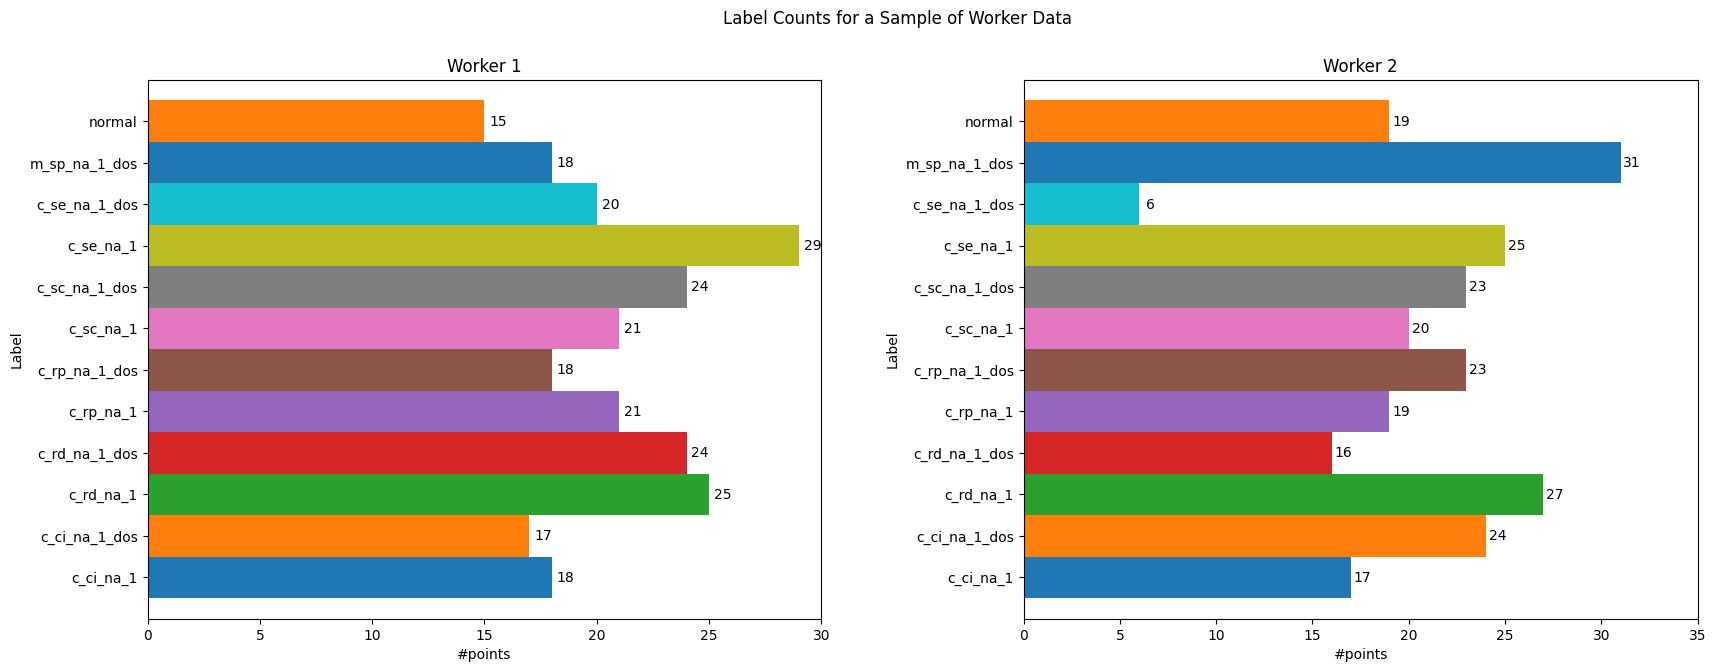

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 7))
fig.suptitle('Label Counts for a Sample of Worker Data')
fig.tight_layout()

for i in range(n_workers):
    m = 0
    plot_data = collections.defaultdict(list)
    for label in list(client_data[i])[0]['y'].numpy()[:,0]:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        plot_data[label].append(label)
        m = max(m, len(plot_data[label]))

    n_cols = n_workers if n_workers < 5 else 5
    xlim = [0, m+(5-m%5)]
    ylim = [min(unique_codes)-1, max(unique_codes)+1]
    yticks = list(range(min(unique_codes), max(unique_codes)+1))
    yticks_labels = [mapping[k] for k in range(0, max(unique_codes)+1)]

    plt.subplot(int(n_workers / 5)+1, n_cols, i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Worker {}'.format(i+1))
    plt.xlabel('#points')
    plt.xlim(xlim)
    plt.ylabel('Label')
    plt.ylim(ylim)
    plt.yticks(yticks, labels=yticks_labels)

    # plot values on top of bars
    for key in plot_data:
        if len(plot_data[key]) > 0:
            plt.text(len(plot_data[key])+0.6, int(key)-0.1, str(len(plot_data[key])), ha='center')

    for j in range(min(unique_codes),max(unique_codes)+1):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[k-0.5 for k in range(min(unique_codes),max(unique_codes)+2)],
            orientation='horizontal'
        )

In [ ]:
def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_shape)),
        tf.keras.layers.Embedding(input_dim=vocabulary_size, output_dim=embedding_dim),
        tf.keras.layers.LSTM(units=128, return_sequences=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(output_shape, kernel_initializer='zeros', activation='relu'),
        tf.keras.layers.Softmax(),
        tf.keras.layers.Dense(output_shape, activation='softmax')
    ])


    return tff.learning.models.from_keras_model(
        model,
        input_spec=collections.OrderedDict(
            x=tf.TensorSpec(shape=[None, input_shape], dtype=tf.float64),
            y=tf.TensorSpec(shape=[None, 1], dtype=tf.int64)),

        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )



In [ ]:
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

NameError: name 'vocabulary_size' is not defined

In [ ]:
print(trainer.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[76,128],
      float32[128],
      float32[128,12],
      float32[12],
      float32[12,12],
      float32[12]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[76,128],
    float32[128],
    float32[128,12],
    float32[12],
    float32[12,12],
    float32[12]
  >
>@SERVER)


In [ ]:
try:
    print("TensorFlow Federated version:", tff.__version__)
    # Print some basic information about TFF
    print("TFF supported attributes:")
    print("tff.aggregators:", dir(tff.aggregators))
    print("tff.backends:", dir(tff.backends))
    print("tff.learning:", dir(tff.learning))
except ImportError:
    print("TensorFlow Federated is not installed.")

TensorFlow Federated version: 0.71.0
TFF supported attributes:
tff.aggregators: ['AggregationFactory', 'DifferentiallyPrivateFactory', 'DiscreteFourierTransformFactory', 'EliasGammaEncodedSumFactory', 'EncodedSumFactory', 'HadamardTransformFactory', 'MeanFactory', 'PrivateQuantileEstimationProcess', 'SecureModularSumFactory', 'SecureSumFactory', 'SumFactory', 'UnweightedAggregationFactory', 'UnweightedMeanFactory', 'UnweightedReservoirSamplingFactory', 'WeightedAggregationFactory', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'add_measurements', 'as_weighted_aggregator', 'clipping_factory', 'concat', 'concat_factory', 'differential_privacy', 'discretization', 'distributed_dp', 'elias_gamma_encode', 'encoded', 'factory', 'factory_utils', 'federated_sample', 'hadamard', 'mean', 'measurements', 'modular_clipping', 'primitives', 'quantile_estimation', 'robust', 'rotation', 'sampling', 'secure', 'secure_quantized_sum',

In [ ]:
def evaluate(num_rounds=10):
    state = trainer.initialize()
    for round in range(num_rounds):
        t1 = time.time()
        result = trainer.next(state, client_data)
        state = result.state
        train_metrics = result.metrics['client_work']['train']
        t2 = time.time()
        print('Round {}: accuracy {}, round time {}'.format(
            round+1, train_metrics['sparse_categorical_accuracy']*100, t2 - t1))

In [ ]:
def evaluate(num_rounds=10):
    state = trainer.initialize()
    for round in range(num_rounds):
        t1 = time.time()
        result = trainer.next(state, client_data)
        state = result.state
        train_metrics = result.metrics['client_work']['train']

        # Assuming 'SparseCategoricalAccuracy' metric is used
        train_accuracy = train_metrics['sparse_categorical_accuracy'] * 100

        t2 = time.time()
        print('Round {}: accuracy {}, round time {}'.format(
            round+1, train_accuracy, t2 - t1))


In [ ]:
evaluate(n_epochs)

Round 1: accuracy 8.082497119903564, round time 1.190964698791504
Round 2: accuracy 8.082497119903564, round time 0.345120906829834
Round 3: accuracy 8.129877597093582, round time 0.3519253730773926
Round 4: accuracy 8.690077811479568, round time 0.3571736812591553
Round 5: accuracy 8.779264241456985, round time 0.35280752182006836
Round 6: accuracy 8.779264241456985, round time 0.36507630348205566
Round 7: accuracy 8.779264241456985, round time 0.3687129020690918
Round 8: accuracy 8.779264241456985, round time 0.35611629486083984
Round 9: accuracy 8.779264241456985, round time 0.3489060401916504
Round 10: accuracy 8.779264241456985, round time 0.34682369232177734
